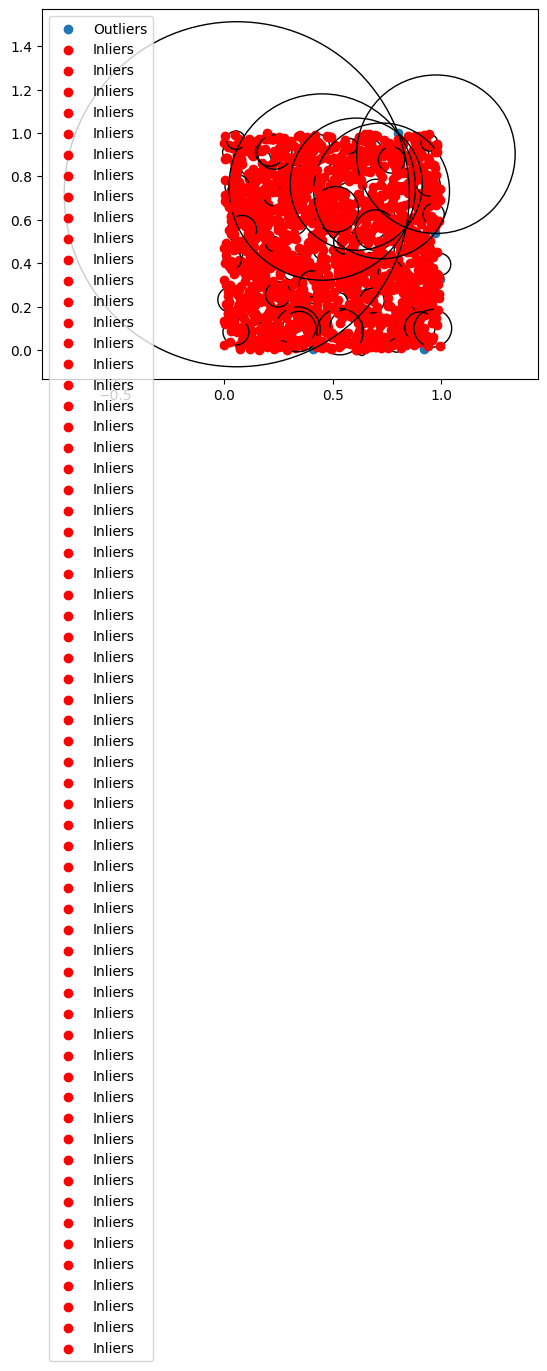

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Load the data
data = np.load("circles.npy")

# Parameters
T = 100  # Number of RANSAC iterations
epsilon = 0.1  # Inlier distance threshold

# Function to calculate the circumcircle given three points
def circumcircle(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    cx = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    cy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    r = np.sqrt((x1 - cx)**2 + (y1 - cy)**2)
    return cx, cy, r


# Function to calculate the squared algebraic distances between a circle and its inliers
def circle_residuals(beta, xei, yei):
    return yei - np.dot(xei, beta)

# Function to fit a circle using RANSAC and then optimize it with ordinary least squares
def fit_circle(data, epsilon):
    # Initialize variables for the best circle
    best_circle = None
    best_inliers = []

    # Perform RANSAC iterations
    for _ in range(T):
        # Randomly choose 3 points
        indices = np.random.choice(len(data), 3, replace=False)
        points = data[indices]

        # Fit the circle using circumcircle formula
        cx, cy, r = circumcircle(*points)

        # Classify inliers
        distances = np.sqrt((data[:, 0] - cx) ** 2 + (data[:, 1] - cy) ** 2)
        inliers = data[distances < epsilon]

        # Update best circle if the current circle has more inliers
        if len(inliers) > len(best_inliers):
            best_circle = (cx, cy, r)
            best_inliers = inliers

    # Check if enough inliers for optimization
    if len(best_inliers) > 2:
        # Nonlinear transformations
        xei = np.column_stack((best_inliers[:, 0], best_inliers[:, 1], np.ones(len(best_inliers))))
        yei = np.sum(best_inliers[:, :2] ** 2, axis=1)

        # Optimize the best circle using ordinary least squares
        initial_params = np.zeros(3)
        optimized_params = least_squares(circle_residuals, initial_params, args=(xei, yei), method='lm').x

        # Extract circle parameters from optimized parameters
        cx = optimized_params[0] / 2
        cy = optimized_params[1] / 2
        r = np.sqrt(cx ** 2 + cy ** 2 + optimized_params[2])

        return (cx, cy, r), best_inliers
    else:
        return best_circle, best_inliers

# Perform circle fitting using RANSAC and ordinary least squares optimization
optimized_circles = []
for _ in range(T):
    optimized_params, inliers = fit_circle(data, epsilon)
    optimized_circles.append((optimized_params, inliers))
    data = data[~np.isin(data, inliers).all(1)]  # Remove inliers for the next iteration

# Plot the original data
plt.scatter(data[:, 0], data[:, 1], label='Outliers')

# Plot the fitted circles
for circle_params, inliers in optimized_circles:
    if circle_params is not None:
        cx, cy, r = circle_params
        circle = plt.Circle((cx, cy), radius=r, fill=False)
        plt.gca().add_patch(circle)
        plt.scatter(inliers[:, 0], inliers[:, 1], color='red', label='Inliers')

plt.axis('equal')
plt.legend()
plt.show()
